In [120]:
from time import time

start = time()

## Regex classifier

In [121]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03FF]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"

            for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                match = re.search(regex_pattern, text)
                if match:
                    pred = lang_code
                    break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [122]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [123]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [124]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [125]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [126]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [127]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
18812,other,Kwa miadi maalum tu unaweza kutembelea palazzo...
81669,other,Forças sírias invadiram o bastião rebelde
24995,other,"Pas de très grande qualité, mais vu le prix on..."
58555,other,"33 bu büyüklükte ekipman , büyük bir kısmı , b..."
61855,other,1865 . Haziran 1865 . ' de savaş esiri olarak ...
...,...,...
50926,other,Papież Franciszek potępia globalną obojętność ...
32238,other,"""Zeker wat we weten suggereert dat we wat ze z..."
83216,other,Haznawi (Uçuş 93) ve Wail al Shehri (Uçuş 11) ...
24994,other,Obama renova oferta para cortar rede de segura...


In [128]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,Papież Franciszek potępia globalną obojętność ...
23996,other,"""Zeker wat we weten suggereert dat we wat ze z..."
23997,other,Haznawi (Uçuş 93) ve Wail al Shehri (Uçuş 11) ...
23998,other,Obama renova oferta para cortar rede de segura...


### Greek-Greeklish identification dataset

In [129]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [130]:
from src.util import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.72it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.64it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.45it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.04it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.29it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.59it/s]


Processing page 7 of 8...


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:02<00:01,  5.18it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.42it/s]


Processing page 8 of 8...


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:01<00:00,  5.23it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.37it/s]


In [131]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

414

In [132]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [133]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [134]:
warmane_df = warmane_df[~empty_contents]

In [135]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(warmane_df.contents)

In [136]:
warmane_df[preds=="en"].contents

id
2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
2557881                          Paokara einai padou file :P
2602989    Me to plevro ton Allience ayti ti fora Oi <<An...
2877428         kalos private aksizei na ksekiniseis paidia?
2801654                                     Bump! ICC25 6/12
2873339    Kalhspera tha ithela na rwthsw an kapoios gnwr...
Name: contents, Length: 227, dtype: object

In [137]:
warmane_df[preds=="greeklish"].contents

Series([], Name: contents, dtype: object)

In [138]:
warmane_df[preds=="el"].contents

id
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
2609122    πώρωση με τα μισά Dung, Quests και Raids bugge...
2707437    Λοιπόν μαγες,ξέρει κάποιος γιατί δεν γίνεται ν...
2777071    INACTIVE\n\n\n <Northern Defiance>  Καινούργια...
3069941    Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2410495    Εμπειρια εχω, αλλα δεν εχω χρονο...αυτο ειναι ...
Name: contents, Length: 180, dtype: object

In [139]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": warmane_df.contents})
gold2_df

,labels,text
id,,
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12


In [140]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12
2873339,greeklish,Kalhspera tha ithela na rwthsw an kapoios gnwr...


In [141]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file)
    print(f"File saved successfully as {file}")

In [142]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [22]:
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver


def new_driver():
    try:
        service = Service()
    except Exception:
        service = Service(ChromeDriverManager().install())
    
    options = webdriver.ChromeOptions()
    options.add_experimental_option('excludeSwitches', ['enable-logging'])
    options.add_argument("--headless")
    options.add_argument('--lang=en')
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36")
    
    return webdriver.Chrome(service=service, options=options)

In [23]:
from tasks.youtube import scrape_youtube, extract_search_results, extract_comments


# "greek songs" search in Greek
search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
driver = new_driver()
search_soup = scrape_youtube(driver, search_url, max_scrolls=5, verbose=True)
driver.quit()

Scrolling (0 out of max 5)...
Scrolling (1 out of max 5)...
Scrolling (2 out of max 5)...
Scrolling (3 out of max 5)...
Scrolling (4 out of max 5)...
Scrolling (5 out of max 5)...


In [24]:
results = extract_search_results(search_soup)
results_df = pd.DataFrame({"title": results[0], "link": results[1]})
results_df

,title,link
0,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...
1,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...
2,\n\nAnastasia - Omorfi | Αναστασία - Όμορφη (O...,/watch?v=f8wpmLCmbas&pp=ygUjzrXOu867zrfOvc65zr...
3,\n\nΜουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χ...,/watch?v=p5g82ta4sTk&pp=ygUjzrXOu867zrfOvc65zr...
4,\n\nGreek Ultra Hits Non Stop Mix By Nikos Hal...,/watch?v=KhCU68Eok9E&pp=ygUjzrXOu867zrfOvc65zr...
...,...,...
125,\n\nΤΟ ΑΛΗΘΙΝΟ ΔΙΑΧΡΟΝΙΚΟ ΕΛΛΗΝΙΚΟ ΤΡΑΓΟΥΔΙ\n,/watch?v=OtMFMWuQgCo&pp=ygUjzrXOu867zrfOvc65zr...
126,\n\nΠάμε Τσάρκα και άλλα Χορευτικά Ρεμπέτικα -...,/watch?v=6pLSHcZbmEo&pp=ygUjzrXOu867zrfOvc65zr...
127,\n\nNina Mazani - Άγχος (Από το “Ενκάντο: Ένας...,/watch?v=-hsjov_72W0&pp=ygUjzrXOu867zrfOvc65zr...
128,\n\nΟ μεγάλος αδερφός και η μεγάλη αδερφή 👶 Πα...,/watch?v=6WsmRoBi_d8&pp=ygUjzrXOu867zrfOvc65zr...


In [25]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
1,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...
2,Anastasia - Omorfi | Αναστασία - Όμορφη (Offic...,https://www.youtube.com/watch?v=f8wpmLCmbas&pp...
3,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
4,Greek Ultra Hits Non Stop Mix By Nikos Halkous...,https://www.youtube.com/watch?v=KhCU68Eok9E&pp...
...,...,...
125,ΤΟ ΑΛΗΘΙΝΟ ΔΙΑΧΡΟΝΙΚΟ ΕΛΛΗΝΙΚΟ ΤΡΑΓΟΥΔΙ,https://www.youtube.com/watch?v=OtMFMWuQgCo&pp...
126,Πάμε Τσάρκα και άλλα Χορευτικά Ρεμπέτικα - Pam...,https://www.youtube.com/watch?v=6pLSHcZbmEo&pp...
127,Nina Mazani - Άγχος (Από το “Ενκάντο: Ένας Κόσ...,https://www.youtube.com/watch?v=-hsjov_72W0&pp...
128,Ο μεγάλος αδερφός και η μεγάλη αδερφή 👶 Παιδικ...,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...


In [26]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
2,Anastasia - Omorfi | Αναστασία - Όμορφη (Offic...,https://www.youtube.com/watch?v=f8wpmLCmbas&pp...
3,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
6,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...
8,40 ελληνικά τραγούδια από τα 60's (by Elias),https://www.youtube.com/watch?v=WIiJc6_4khQ&pp...
...,...,...
124,Greek Mix 2023 | Ελληνικά Remix | Galaxy Music,https://www.youtube.com/watch?v=NXFXiKjKgQg&pp...
125,ΤΟ ΑΛΗΘΙΝΟ ΔΙΑΧΡΟΝΙΚΟ ΕΛΛΗΝΙΚΟ ΤΡΑΓΟΥΔΙ,https://www.youtube.com/watch?v=OtMFMWuQgCo&pp...
126,Πάμε Τσάρκα και άλλα Χορευτικά Ρεμπέτικα - Pam...,https://www.youtube.com/watch?v=6pLSHcZbmEo&pp...
127,Nina Mazani - Άγχος (Από το “Ενκάντο: Ένας Κόσ...,https://www.youtube.com/watch?v=-hsjov_72W0&pp...


In [27]:
import threading


driver = new_driver()

def get_driver():
    return driver

def scrape_job(yt_url):
    driver = get_driver()
    try:
        result = scrape_youtube(driver, yt_url, scroll_wait_secs=2,
                       max_scrolls=5, verbose=False)
    except Exception:
        result = None
    return yt_url, result

In [28]:
import concurrent.futures

jobs = 8
urls = gr_res_df.link[0:60]

print("Scrapping comments...")
with concurrent.futures.ThreadPoolExecutor(max_workers=jobs) as executor:
    results = list(tqdm(executor.map(scrape_job, urls), total=len(urls)))
driver.quit()

Scrapping comments...


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [02:18<00:00,  2.31s/it]


In [29]:
from tasks.youtube import extract_comments


scraped_urls = []
comments = []
dates = []

for url, result in results:
    if result is not None:
        new_comments, new_dates = extract_comments(result)
        comments += new_comments
        dates += new_dates
        scraped_urls += ([url] * len(new_comments))

In [30]:
crawl_df = pd.DataFrame({"video": scraped_urls, "text": comments, "date": dates})
crawl_df

,video,text,date
0,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Great songs of an amazing singer. I had the o...,2022-11-25 10:14:43.874005
1,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,"τεράστιος και σε φωνή , και σε ψυχή .",2021-11-25 10:14:43.880144
2,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ότι αρχίζει με χαρά τελειώνει με κάρα,2023-02-25 10:14:43.886325
3,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,"Ελληνικά τραγούδια , ελληνική ψυχή, ελληνικό μ...",2023-02-25 10:14:43.894323
4,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Η ωραιοτερη γνησια λαικη φωνη που υπαρχει τωρα...,2023-10-25 10:14:43.900553
...,...,...,...
861,https://www.youtube.com/watch?v=XvjZj1Ypcl8&pp...,️️,2021-11-25 10:14:48.478917
862,https://www.youtube.com/watch?v=XvjZj1Ypcl8&pp...,Ειμαι εδω και εισαι εκει,2021-11-25 10:14:48.481917
863,https://www.youtube.com/watch?v=XvjZj1Ypcl8&pp...,️,2021-11-25 10:14:48.486157
864,https://www.youtube.com/watch?v=XvjZj1Ypcl8&pp...,!,2022-11-25 10:14:48.490160


In [31]:
sum(crawl_df.date != None)

866

In [32]:
crawl_df[crawl_df.text.apply(lambda x: x.isspace())]

,video,text,date


In [145]:
preds = greeklish_model.predict(crawl_df.text)
mask = (preds != "el") & (preds != "greeklish")
crawl_df[mask]

,video,text,date
0,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Great songs of an amazing singer. I had the o...,2022-11-25 10:14:43.874005
5,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,"Очень красиво, влюбилась в голос ,песни и музы...",2021-11-25 10:14:43.904534
8,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Ela re Vasilis...love him from an Albanian in ...,2021-11-25 10:14:43.918941
10,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Can't believe his voice !!! incredible!!!,2023-10-25 10:14:43.928145
13,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Karras..the King of the night!!!! Love from Se...,2023-10-25 10:14:43.938331
...,...,...,...
843,https://www.youtube.com/watch?v=NnJYfR6aQ3s&pp...,X,2022-11-25 10:14:48.367503
861,https://www.youtube.com/watch?v=XvjZj1Ypcl8&pp...,️️,2021-11-25 10:14:48.478917
863,https://www.youtube.com/watch?v=XvjZj1Ypcl8&pp...,️,2021-11-25 10:14:48.486157
864,https://www.youtube.com/watch?v=XvjZj1Ypcl8&pp...,!,2022-11-25 10:14:48.490160


In [35]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


## Language Identification

In [154]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(gold_df, test_size=0.2, 
                                         random_state=42, stratify=gold_df.labels)
data_train

,labels,text
23046,other,Hakuna kitu. tuppence nodded gloomily .
23212,other,Pense que era todo rosa pero solo son los bord...
18110,other,4人家族ですが、一食分に食器や調理器具まで含めて丁度良いサイズです。
22530,other,il fisico Danilov è stato condannato per aver ...
10563,other,उद ् देशिका राज ् य के लिए उद ् देशिका में विश...
...,...,...
23007,other,अल ् बानी में अल ् बेनी ने अल ् बेनी के कानूनी...
23607,other,หาก คุณ กำลัง เดินทาง ทางรถไฟ ยาว อย่า พึ่งพา ...
17279,other,げんこつの部分がプロテクターのせいで痛くなります。 通勤やちょっとお買い物に行く程度で使って...
5066,en,This product was not for dogs. Definitely for ...


In [155]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19525, 79572), (19525,), (4882, 79572), (4882,))

In [156]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [157]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.19030702867292565
              precision    recall  f1-score   support

          el       0.00      0.00      0.00       936
          en       0.00      0.00      0.00       900
   greeklish       0.00      0.00      0.00        46
       other       0.61      1.00      0.76      3000

    accuracy                           0.61      4882
   macro avg       0.15      0.25      0.19      4882
weighted avg       0.38      0.61      0.47      4882



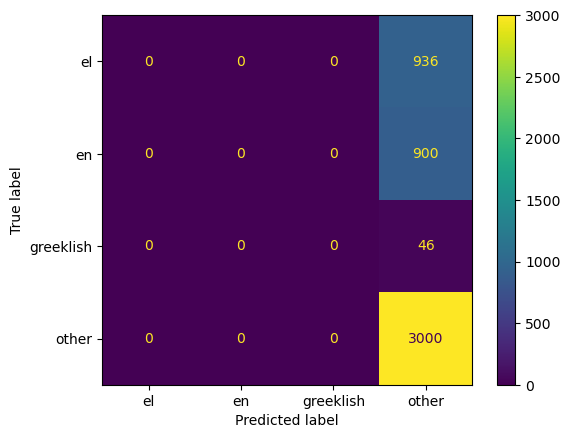

In [158]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [159]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.5117, std: 0.5053


Macro F1: 0.5148711759461488
              precision    recall  f1-score   support

          el       1.00      1.00      1.00       936
          en       0.33      1.00      0.49       900
   greeklish       0.00      0.00      0.00        46
       other       1.00      0.40      0.57      3000

    accuracy                           0.62      4882
   macro avg       0.58      0.60      0.51      4882
weighted avg       0.87      0.62      0.63      4882



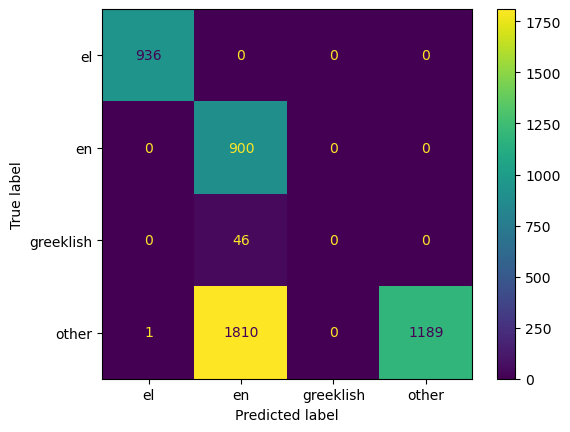

In [160]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Logistic Regression

In [161]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8149, std: 0.8535


Macro F1: 0.894780192672954
              precision    recall  f1-score   support

          el       1.00      0.94      0.97       936
          en       0.99      0.97      0.98       900
   greeklish       1.00      0.48      0.65        46
       other       0.97      1.00      0.98      3000

    accuracy                           0.98      4882
   macro avg       0.99      0.85      0.89      4882
weighted avg       0.98      0.98      0.98      4882



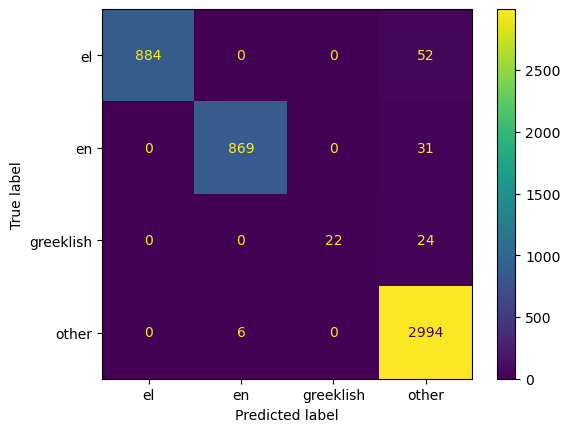

In [162]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

In [175]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=3)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Random Forest mean macro F1: 0.9204, std: 0.9572


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


Macro F1: 0.9671805092315233
              precision    recall  f1-score   support

          el       1.00      0.99      0.99       936
          en       0.98      1.00      0.99       900
   greeklish       0.97      0.83      0.89        46
       other       0.99      0.99      0.99      3000

    accuracy                           0.99      4882
   macro avg       0.99      0.95      0.97      4882
weighted avg       0.99      0.99      0.99      4882



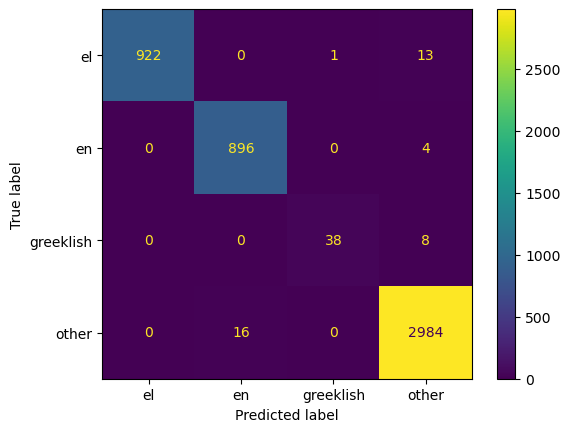

In [176]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

In [178]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=50)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.8448, std: 0.8997


Macro F1: 0.9076711010956788
              precision    recall  f1-score   support

          el       0.99      0.93      0.96       936
          en       0.99      0.94      0.96       900
   greeklish       0.96      0.59      0.73        46
       other       0.96      1.00      0.98      3000

    accuracy                           0.97      4882
   macro avg       0.98      0.86      0.91      4882
weighted avg       0.97      0.97      0.97      4882



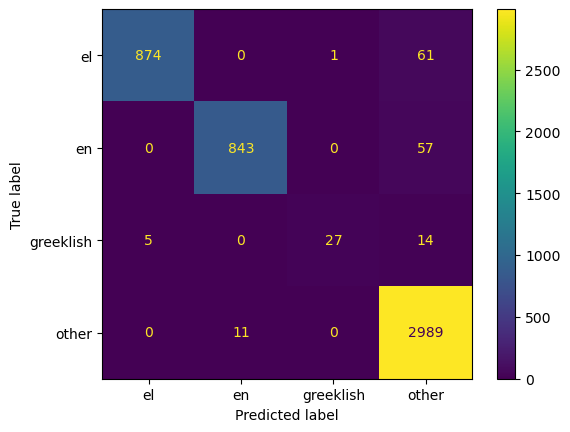

In [179]:
ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [180]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
3598,other,el,"Ο Γ. Πιτ έχει εκατοντάδες παραλίες , από μικρο..."
3279,other,en,Didn't last a week after using.
6494,other,el,Εις βάρος της μεσαίας τάξης .
8423,other,en,It already stopped working. It no longer charges.
5526,other,el,"Ο ' λφρεντ ίγκλθορπ , φυσικά !"
...,...,...,...
6290,other,el,"Κύριε , μου χάλασες τη μέρα ."
2010,other,en,if something spills inside it will leak if you...
4468,other,en,Similar to other books
2558328,el,greeklish,ti 8a kanete kamia guild h mpa?


In [181]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
5526,other,el,"Ο ' λφρεντ ίγκλθορπ , φυσικά !"
2954,other,el,Ακόμα οδηγεί .
259,other,el,Εθνικό Ίδρυμα Επιστημών .
3146630,other,greeklish,tha pexete season 3 gt endiaferome na mpo
2486513,other,greeklish,8a apanthsei kaneis ti fasi?
2454693,other,greeklish,aloha mages tha borouse kaneis na me helparei ...
765,other,el,Προκάλεσε κάποια ζημιά .
2968333,other,greeklish,aoua aoua aoua
2843005,other,greeklish,Resto Shaman twra kanw gear up 3.1k gs Name:Je...
2877428,other,greeklish,kalos private aksizei na ksekiniseis paidia?


In [182]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 23 minutes and 31.3 seconds
